<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s7/S7_process_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),  
     transforms.RandomRotation(10),  
     transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),  
     transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



 ship  ship  ship  bird


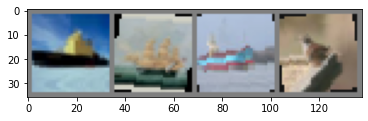

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
# depth wise convolutions
# dilated convolutions

import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block - 32x32x3 -> 10 
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32 ,Reseptive Field 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) ### output_size = 30 ,Reseptive Field 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 ,Reseptive Field 6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3),dilation=2,padding = 1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            #nn.Dropout(dropout_value)
        ) # output_size = 16 ,Reseptive Field 14

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ,Reseptive Field 16

        # CONVOLUTION BLOCK 3
        self.depthwise = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
        self.pointwise = nn.Conv2d(64, 128, kernel_size=1)

        ###output_size =8 , Reseptive field 24

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 4 ,Reseptive Field 28


        # CONVOLUTION BLOCK 4
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3),padding=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 4 ,Reseptive Field 44
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3),padding=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4 ,Reseptive Field 60

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1, Reseptive Field 60

        self.convblock7 = nn.Sequential(
              nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 1, Reseptive Field 54



        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.pool2(x)
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.pool3(x)
        x = self.convblock5(x)      
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
#net = Net()

In [ ]:
##PoojaDi
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
            
        ) #i/p=32, output_size = 30  Rf 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(64)
            
        ) # i/p=30,output_size = 32 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),    
            
        ) # i/p=30,output_size = 32 RF 5 Jout -1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # i./p=32,output_size = 16  RF 6 Jout - 2


        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False,dilation=2),  ##dilation
            nn.ReLU(),
            nn.BatchNorm2d(128)
           ) #i/p=16 output_size =12  RF 14 Jout - 2

       # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) #i/p=12 output_size = 6  RF 16 Jout - 4
        
          #CONVOLUTION BLOCK 3
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            ) # i/p=6,output_size =8  RF -24 ,Jout - 4

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # i/p=8,output_size = 4  RF 32 Jout - 8

       #CONVOLUTION BLOCK 4

        self.depthwise = nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128)
        self.pointwise = nn.Conv2d(128, 64, kernel_size=1)

        # i/p=4,output_size =4  RF 48 Jout - 8


        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.pool3(x)
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.gap(x)        
        x = self.convblock9(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
            Conv2d-4           [-1, 64, 32, 32]          18,432
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]           4,096
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 12, 12]          73,728
             ReLU-10          [-1, 128, 12, 12]               0
      BatchNorm2d-11          [-1, 128, 12, 12]             256
        MaxPool2d-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 128, 8, 8]         147,456
             ReLU-14            [-

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001 )

In [ ]:
images=images.to(device)
outputs = model(images)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
def truth_checker(model,loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [ ]:
class training_class:
  def __init__(self,model,trainloader,testloader,epoch):
    self.model = model
    self.trainloader = trainloader
    self.testloader = testloader
    self.epoch = epoch

  def fit(self):
    for x_epoch in range(self.epoch):
      running_loss  = 0.0
      for i,data in enumerate(self.trainloader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = self.model(inputs)
        ###Loss 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
      ###Epoch Loss
      test_check = truth_checker(self.model,self.testloader)
      #train_check = truth_checker(self.model,self.trainloader)
      print('epoch [%d] train accuracy LUL : test accuracy %.3f' % (x_epoch,test_check) )


  def _save_model(self):
    return self.model

In [ ]:
clf = training_class(model,trainloader,testloader,50)

In [ ]:
clf.fit()

epoch [0] train accuracy LUL : test accuracy 0.570
epoch [1] train accuracy LUL : test accuracy 0.616
epoch [2] train accuracy LUL : test accuracy 0.651
epoch [3] train accuracy LUL : test accuracy 0.672
epoch [4] train accuracy LUL : test accuracy 0.692
epoch [5] train accuracy LUL : test accuracy 0.702
epoch [6] train accuracy LUL : test accuracy 0.710
epoch [7] train accuracy LUL : test accuracy 0.724
epoch [8] train accuracy LUL : test accuracy 0.721
epoch [9] train accuracy LUL : test accuracy 0.733
epoch [10] train accuracy LUL : test accuracy 0.736
epoch [11] train accuracy LUL : test accuracy 0.732
epoch [12] train accuracy LUL : test accuracy 0.745
epoch [13] train accuracy LUL : test accuracy 0.760
epoch [14] train accuracy LUL : test accuracy 0.751
epoch [15] train accuracy LUL : test accuracy 0.757
epoch [16] train accuracy LUL : test accuracy 0.749
epoch [17] train accuracy LUL : test accuracy 0.756
epoch [18] train accuracy LUL : test accuracy 0.767
epoch [19] train accur

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


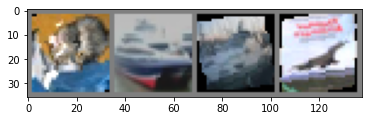

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
images = images.to(device)
outputs = model(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 84 %
Accuracy of  bird : 67 %
Accuracy of   cat : 74 %
Accuracy of  deer : 81 %
Accuracy of   dog : 52 %
Accuracy of  frog : 87 %
Accuracy of horse : 83 %
Accuracy of  ship : 89 %
Accuracy of truck : 87 %
